# Download dataset

In [1]:
!rm -rf /content/ds
!mkdir /content/ds
!mkdir /content/ds/images/
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_0.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_1.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_2.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_3.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_4.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_5.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_400_class_6.pt'
!wget 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_400_class_7.pt'

--2021-11-23 10:03:55--  https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/netG_200_class_0.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dyussekeyev/age-and-gender-classification/main/models/netG_200_class_0.pt [following]
--2021-11-23 10:03:55--  https://raw.githubusercontent.com/dyussekeyev/age-and-gender-classification/main/models/netG_200_class_0.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14324954 (14M) [application/octet-stream]
Saving to: ‘netG_200_class_0.pt’

netG_200_class_0.pt 100%[===================>]  13.66M  --.-KB/s    in 0.1s    

2021-11-

# Imports

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import cv2
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


# Init Models

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [5]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
netG = []

netG.append(torch.load('/content/netG_200_class_0.pt'))
netG.append(torch.load('/content/netG_200_class_1.pt'))
netG.append(torch.load('/content/netG_200_class_2.pt'))
netG.append(torch.load('/content/netG_200_class_3.pt'))
netG.append(torch.load('/content/netG_200_class_4.pt'))
netG.append(torch.load('/content/netG_200_class_5.pt'))
netG.append(torch.load('/content/netG_400_class_6.pt'))
netG.append(torch.load('/content/netG_400_class_7.pt'))

netG[0].eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Generate Images

In [7]:
for cls in range(8):
    print('Class: ' + str(cls))
    noise = torch.randn(4, 100, 1, 1, device=device)
    fake_images = netG[cls](noise).detach().cpu()

    for i in range(4):
        fname = '/content/ds/images/class_' + str(cls) + '_' + str(i) + '.jpg'
        norm_image = cv2.normalize(np.float32(fake_images[i].permute(1, 2, 0)), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        norm_image = np.ubyte(norm_image)

        fig = plt.figure(frameon=False)
        fig.set_size_inches(1,1)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        #ax.imshow(norm_image, aspect='auto')
        plt.close(fig)
        fig.savefig(fname, dpi = 64)

Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Class: 5
Class: 6
Class: 7


In [8]:
!zip -r images.zip /content/ds/images

  adding: content/ds/images/ (stored 0%)
  adding: content/ds/images/class_5_0.jpg (deflated 40%)
  adding: content/ds/images/class_5_2.jpg (deflated 40%)
  adding: content/ds/images/class_7_0.jpg (deflated 40%)
  adding: content/ds/images/class_6_3.jpg (deflated 40%)
  adding: content/ds/images/class_7_1.jpg (deflated 40%)
  adding: content/ds/images/class_0_0.jpg (deflated 40%)
  adding: content/ds/images/class_3_3.jpg (deflated 40%)
  adding: content/ds/images/class_4_0.jpg (deflated 40%)
  adding: content/ds/images/class_4_1.jpg (deflated 40%)
  adding: content/ds/images/class_1_0.jpg (deflated 40%)
  adding: content/ds/images/class_6_0.jpg (deflated 40%)
  adding: content/ds/images/class_2_2.jpg (deflated 40%)
  adding: content/ds/images/class_4_3.jpg (deflated 40%)
  adding: content/ds/images/class_4_2.jpg (deflated 40%)
  adding: content/ds/images/class_6_1.jpg (deflated 40%)
  adding: content/ds/images/class_5_3.jpg (deflated 40%)
  adding: content/ds/images/class_7_3.jpg (defl

Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Class: 5
Class: 6
Class: 7


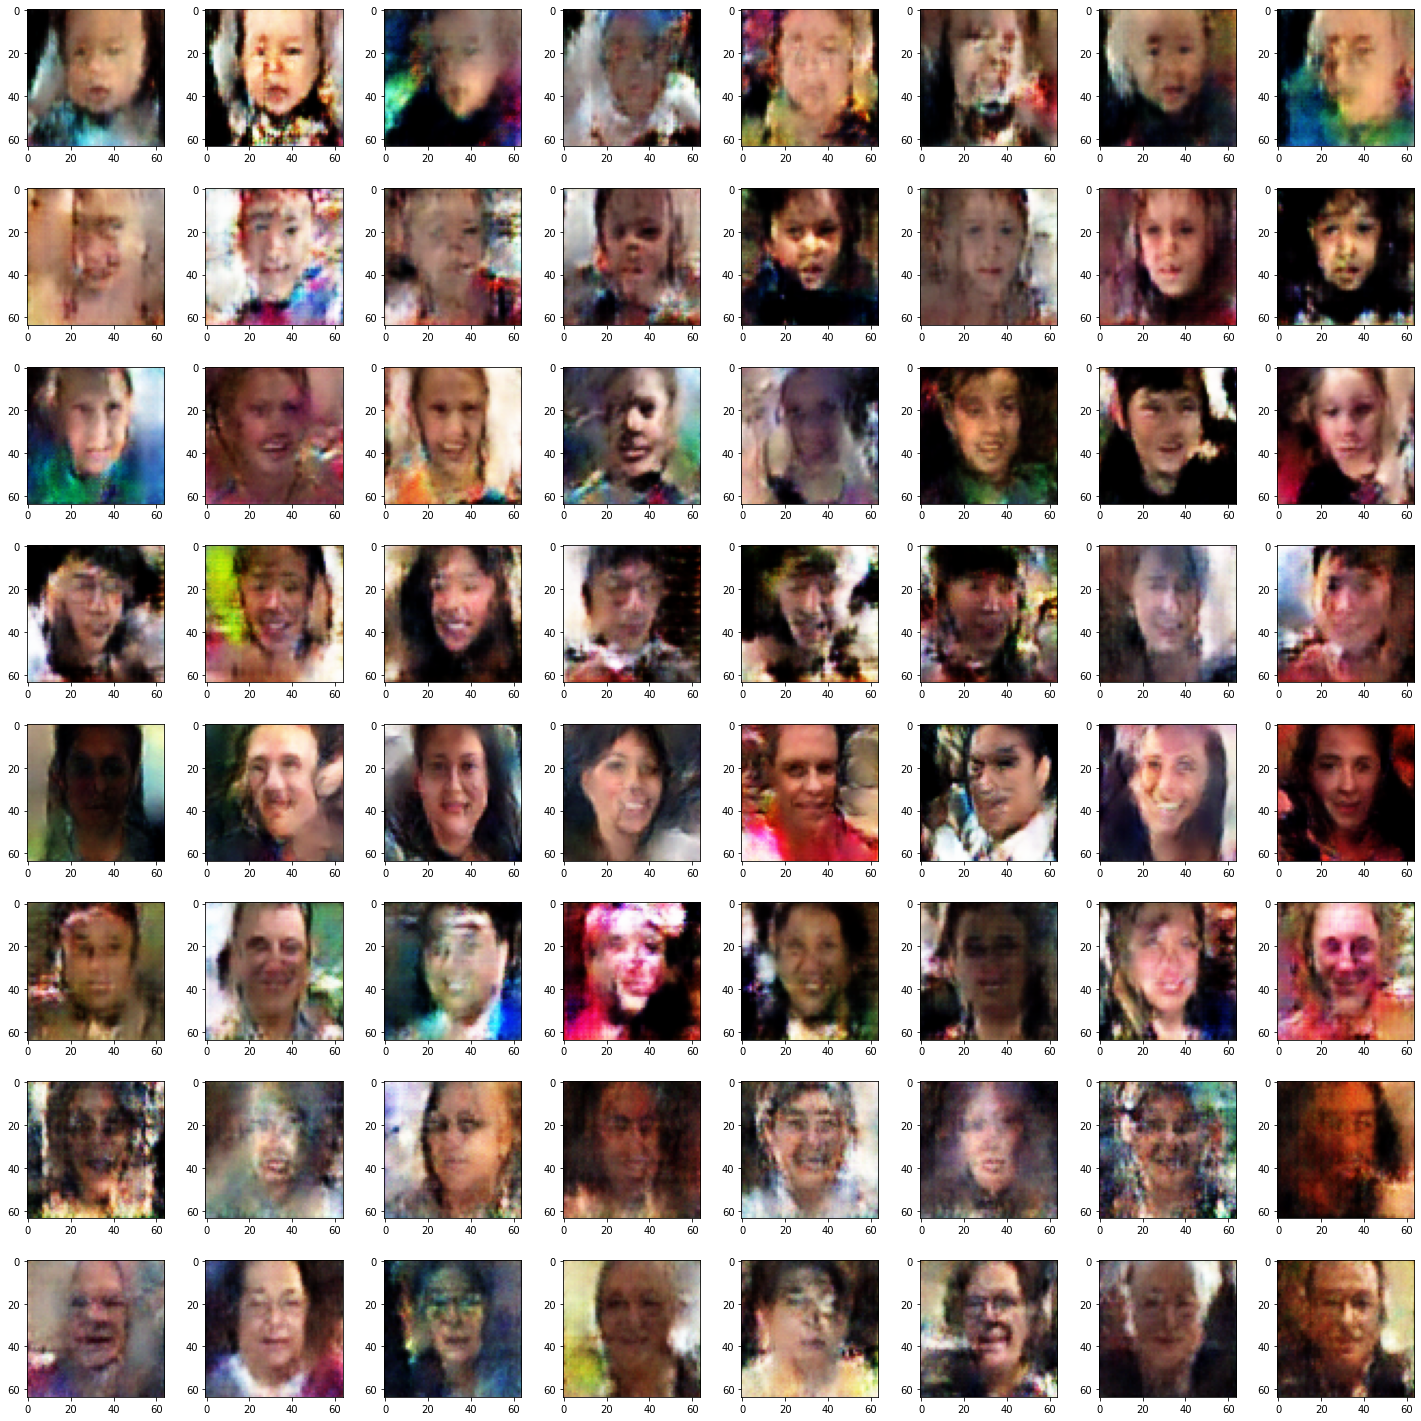

In [9]:
myimages = []

for i in range(8):
    print('Class: ' + str(i))
    noise = torch.randn(16, 100, 1, 1, device=device)
    fake_images = netG[i](noise).detach().cpu()

    for j in range(8):
        fname = '/content/ds/images/class_' + str(i) + '_' + str(j) + '.jpg'
        fake_images[j].permute(1, 2, 0)
        norm_image = cv2.normalize(np.float32(fake_images[j].permute(1, 2, 0)), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        norm_image = np.ubyte(norm_image)

        myimages.append(norm_image)

f, axarr = plt.subplots(8,8,figsize=(20,20))
f.tight_layout()

for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(myimages[i*8+j])

In [10]:
print('end')

end
